## plot_NRJ-n-ModScat_any

plot various diags for checking robustness of modal decomposition and scattering diagnostics (eg compare NRJ balance terms, ...)

for comparison with btrop/bclin NRJ decomposition, see notebook plot_BclinNRJ_evol.ipynb (in NRJ_flux_diags/)

#### what is shown here
* balance terms
* barotropic-> baroclinic terms, from modal decomp and btrop/bclin decomposition, linear theory and simulation

In [21]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import numpy as np
import sys, os
from netCDF4 import Dataset, MFDataset
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import scipy.interpolate as itp
from PIL import Image, ImageDraw
import json
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [22]:
simul = "luckyt"
if simul in ['luckyt']:
    season = "_win"
    app = ""
else:
    season = ""
    app = "-b"
app += season

grid_file = KRYPTON+"/lucky_corgrd.nc"
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
dirpic = 'pictures/scatdiag_process/'
dosavefig = True

# modal stuff
filscat = KRYPTON+'{0}_modemap/{0}_mode_scatdiag{1}.nc'.format(simul,app)
filcsv = "./{0}_diagscat{1}.csv".format(simul,app)
data_Fa14 = KRYPTON+"Tide_Conv/Falahat_etal_2014_ModalConvM2.nc"

# diag NRJ
filNRJ = "../NRJ_flux_diag/{0}_NRJ_diags.pkl".format(simul)

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)
      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)

# load dataframe(s)
#datfra = pd.read_csv(filcsv, header=[0,1], index_col=0)#, converters={'Cmn': eval})
datfra = pd.read_pickle(filcsv.replace("csv","pkl"))
nmod = len(datfra)
datnrj = pd.read_pickle(filNRJ)

# load netCDF file
nc = Dataset(filscat, "r")
print("variables in {}:".format(filscat),nc.variables.keys())
nc.close()
rho0 = 1025

variables in /data0/project/vortex/lahaye/luckyt_modemap/luckyt_mode_scatdiag_win.nc: odict_keys(['time', 'xi_rho', 'eta_rho', 'ocean_time', 'lon_rho', 'lat_rho', 'KE', 'APE', 'TotE', 'KEtser', 'PEtser', 'divf', 'divf_out', 'divf_islands', 'divf_seamounts', 'divf_ridge1', 'divf_ridge2', 'divf_ridge3', 'divf_ridge4', 'divf_full', 'Cmn', 'Cmn_tser', 'Cbcl', 'DissTot', 'DissRes'])


<IPython.core.display.Javascript object>


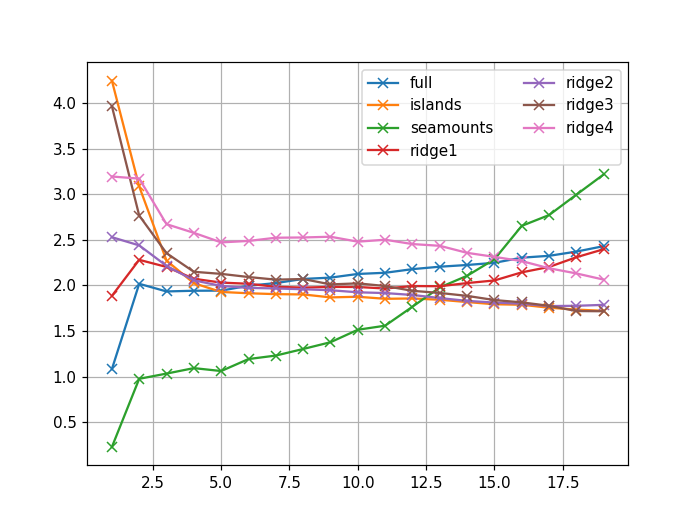

In [5]:
(datfra.KE/datfra.PE).iloc[1:].plot(marker="x")
plt.grid(True)
plt.legend(ncol=2)

In [23]:
# load data time series
nc = Dataset(filscat, "r")
time = nc.variables['time'][:]
ketser = nc.variables['KEtser'][:]
nc.close()
modes = np.arange(ketser.shape[1])

<IPython.core.display.Javascript object>


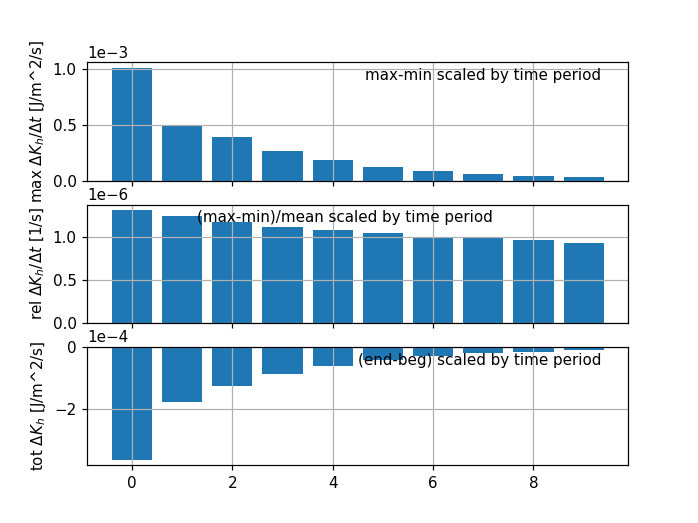

In [24]:
### plot modal NRJ variations

fig, axs = plt.subplots(3, 1, sharex=True)

# max variation
data = (ketser.max(axis=0)-ketser.min(axis=0))/(time[-1]-time[0])*1e3/3600
ax = axs[0]
ax.bar(np.arange(nmod), data)
ax.set_ylabel(r'max $\Delta K_h/\Delta t$ [J/m^2/s]')
ax.text(.95,.95,"max-min scaled by time period", transform=ax.transAxes, va="top", ha="right")
# relative variation
data /= ketser.mean(axis=0)*1e3
ax = axs[1]
ax.bar(np.arange(nmod), data)
ax.set_ylabel(r'rel $\Delta K_h/\Delta t$ [1/s]')
ax.text(.75,.95,"(max-min)/mean scaled by time period", transform=ax.transAxes, va="top", ha="right")

# whole time series tendency
data = (ketser[-1,:]-ketser[0,:])/(time[-1]-time[0])*1e3/3600
ax = axs[2]
ax.bar(np.arange(nmod), data)
ax.set_ylabel(r'tot $\Delta K_h$ [J/m^2/s]')
ax.text(.95,.95,"(end-beg) scaled by time period", transform=ax.transAxes, va="top", ha="right")

for ax in axs:
    ax.grid(True)
    ax.ticklabel_format(style='sci',scilimits=(-2,3),axis="y")
    
if dosavefig:
    fig.savefig(dirpic+"{0}_modeNRJ_bar{1}.pdf".format(simul,app), magnification="auto", bbox_inches="tight")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


<IPython.core.display.Javascript object>


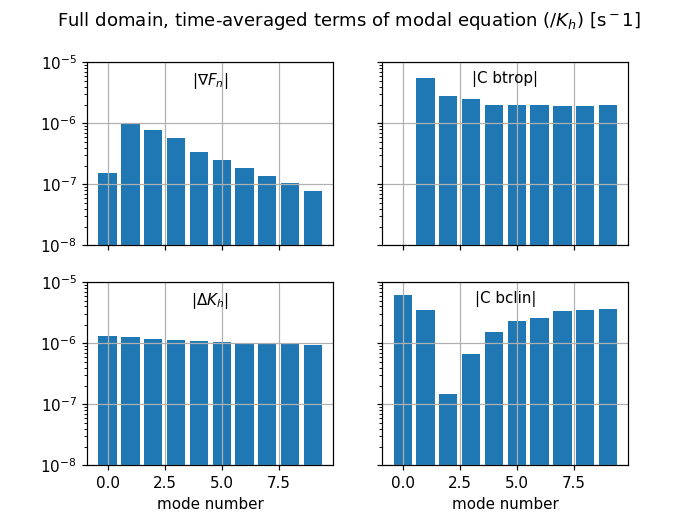

In [25]:
# compare with mean flux divergence and Cbc, Cbt
nc = Dataset(filscat, "r")
divf= nc.variables['divf_full'][:].mean(axis=0)
cbtr = nc.variables['Cmn_tser'][0,:,:].mean(axis=-1)
cbcl = np.nanmean(nc.variables['Cbcl'][:], axis=(-1,-2))
nc.close()

fig, bxs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = bxs.ravel()
#plot relative mean divf
data = abs(divf)/(ketser.mean(axis=0)*1e3)
ax = bxs[0,0]
ax.bar(modes[:], data[:], log=True)
ax.text(.5, .95, r'$|\nabla F_n|$', ha="center", va="top", transform=ax.transAxes)

data = (ketser.max(axis=0)-ketser.min(axis=0))/(time[-1]-time[0])/3600./ketser.mean(axis=0)
ax = bxs[1,0]
ax.bar(modes[:], data[:], log=True)
data = abs(cbtr)/(ketser.mean(axis=0)*1e3)
ax.text(.5, .95, r'$|\Delta K_h|$', ha="center", va="top", transform=ax.transAxes)

ax = bxs[0,1]
ax.bar(modes[:], data[:], log=True)
ax.text(.5, .95, '|C btrop|', ha="center", va="top", transform=ax.transAxes)

data = abs(cbcl)/(ketser.mean(axis=0)*1e3)
ax = bxs[1,1]
ax.bar(modes[:], data[:], log=True)
ax.text(.5, .95, '|C bclin|', ha="center", va="top", transform=ax.transAxes)

for ax in axs:
    ax.grid(True)
    ax.set_ylim([1e-8, 1e-5])
for ax in bxs[1,:]:
    ax.set_xlabel('mode number') 
    
fig.suptitle(r'Full domain, time-averaged terms of modal equation (/$K_h$) [s$^-1$]')

if dosavefig:
    fig.savefig(dirpic+"{0}_modeNRJ_termsBal{1}.pdf".format(simul,app), \
                magnification="auto", bbox_inches="tight")

<IPython.core.display.Javascript object>


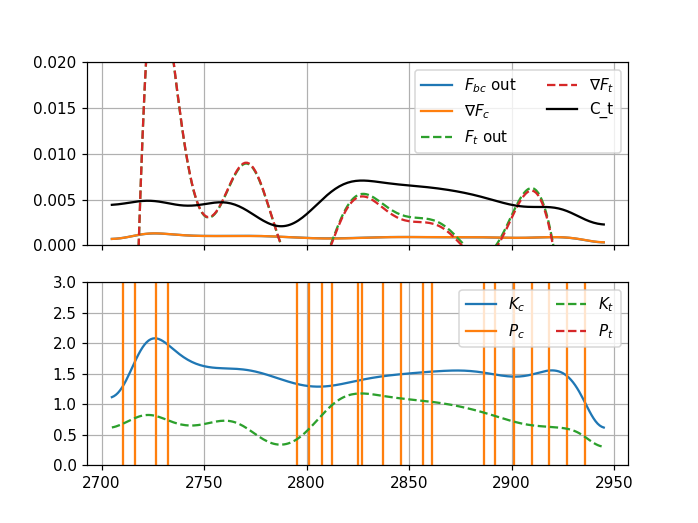

In [26]:
# time series of total btrop conversion and btrop & bclin flux divergence
if simul in ['luckyt']:
    limyW = [0, 2e-2]
else:
    limyW = [0, 7e-3]
    
nc = Dataset(filscat, "r")
divfbc = nc.variables['divf_full'][:,1:].sum(axis=-1)
divfbt = nc.variables['divf_full'][:,0]
foutbc = nc.variables['divf_out'][:,1:].sum(axis=-1)
foutbt = nc.variables['divf_out'][:,0]
kebcl = nc.variables['KEtser'][:,1:].sum(axis=-1)
pebcl = nc.variables['PEtser'][:,1:].sum(axis=-1)
kebtr = nc.variables['KEtser'][:,0]
pebtr = nc.variables['PEtser'][:,0]
cbtr = nc.variables['Cmn_tser'][0,1:,:].sum(axis=0)
nc.close()

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
ax.plot(time, foutbc, label=r"$F_{bc}$ out")
ax.plot(time, divfbc, label=r"$\nabla F_c$")
ax.plot(time, foutbt, "--", label=r"$F_t$ out")
ax.plot(time, divfbt, "--", label=r"$\nabla F_t$")
ax.plot(time, cbtr, "k", label="C_t")
ax.set_ylim(limyW)
ax.legend(ncol=2)
        
ax = axs[1]
ax.plot(time, kebcl, label=r"$K_c$")
ax.plot(time, pebcl, label=r"$P_c$")
ax.plot(time, kebtr, "--", label=r"$K_t$")
ax.plot(time, pebtr, "--", label=r"$P_t$")
ax.set_ylim([0, 3])
ax.legend(ncol=2)

for ax in axs:
    ax.grid(True)
    
if dosavefig:
    fig.savefig(dirpic+"{0}_modeNRJ_evol{1}.pdf".format(simul,app), \
                magnification="auto", bbox_inches="tight")

## Conversion term
compare linear calculation vs. numerical simulation, modal vs. btrop/bclin decomposition

* linear theory, btrop/bclin from Nycander conv
* linear theory, modal decomposition from Falahat & Nycander 2014


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


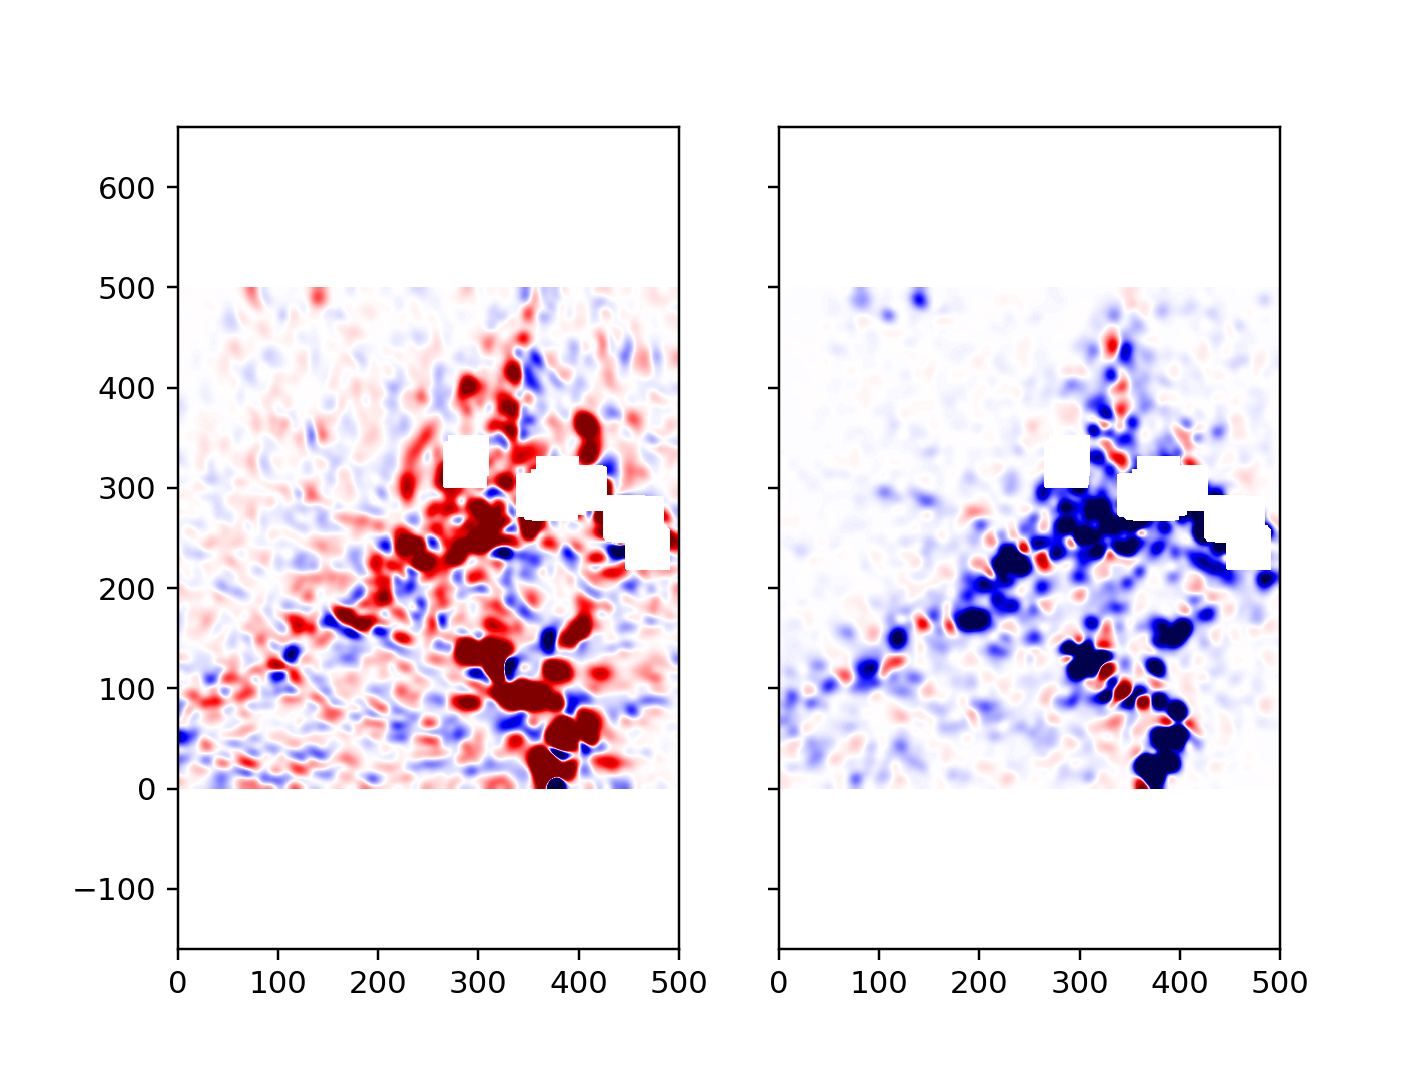

In [38]:
imod = 1
nc = Dataset(filscat, "r")
cbt = nc.variables['Cmn'][0,imod,:,:]*1e3
cbc = nc.variables['Cbcl'][imod,:,:]*1e3
nc.close()

blurit = lambda x: gaussian_filter(x, sigma=5, mode="reflect")

vamp = 10
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].pcolormesh(blurit(cbt), vmin=-vamp, vmax=vamp, cmap="seismic")
axs[1].pcolormesh(blurit(cbc), vmin=-vamp, vmax=vamp, cmap="seismic")
for ax in axs:
    ax.set_aspect(1)

## Dissipation

In [37]:
nc = Dataset(filscat, "r")
diss = nc.variables['']